# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

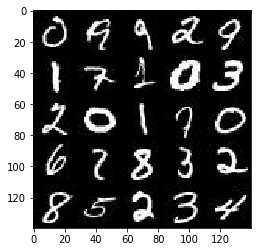

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

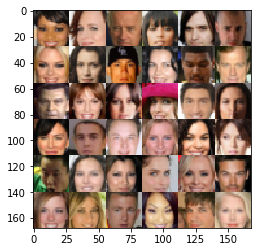

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.5
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.4829... Generator Loss: 0.4857
Epoch 1/2... Batch 20... Discriminator Loss: 0.4913... Generator Loss: 2.9511
Epoch 1/2... Batch 30... Discriminator Loss: 0.5614... Generator Loss: 2.1336
Epoch 1/2... Batch 40... Discriminator Loss: 0.4371... Generator Loss: 3.2393
Epoch 1/2... Batch 50... Discriminator Loss: 0.5024... Generator Loss: 3.3881
Epoch 1/2... Batch 60... Discriminator Loss: 0.5429... Generator Loss: 2.3517
Epoch 1/2... Batch 70... Discriminator Loss: 0.4756... Generator Loss: 2.7731
Epoch 1/2... Batch 80... Discriminator Loss: 0.6087... Generator Loss: 2.2275
Epoch 1/2... Batch 90... Discriminator Loss: 2.5012... Generator Loss: 0.4003
Epoch 1/2... Batch 100... Discriminator Loss: 1.2210... Generator Loss: 0.9780


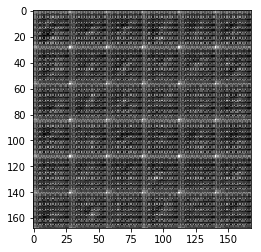

Epoch 1/2... Batch 110... Discriminator Loss: 1.2195... Generator Loss: 0.7814
Epoch 1/2... Batch 120... Discriminator Loss: 0.8379... Generator Loss: 1.5136
Epoch 1/2... Batch 130... Discriminator Loss: 0.9651... Generator Loss: 1.2032
Epoch 1/2... Batch 140... Discriminator Loss: 1.2928... Generator Loss: 0.7718
Epoch 1/2... Batch 150... Discriminator Loss: 1.1745... Generator Loss: 0.8502
Epoch 1/2... Batch 160... Discriminator Loss: 1.2795... Generator Loss: 0.7065
Epoch 1/2... Batch 170... Discriminator Loss: 1.3823... Generator Loss: 0.5594
Epoch 1/2... Batch 180... Discriminator Loss: 1.2084... Generator Loss: 0.7330
Epoch 1/2... Batch 190... Discriminator Loss: 1.0435... Generator Loss: 2.1252
Epoch 1/2... Batch 200... Discriminator Loss: 1.0006... Generator Loss: 0.9845


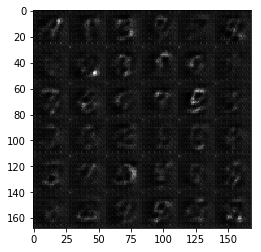

Epoch 1/2... Batch 210... Discriminator Loss: 1.0927... Generator Loss: 2.4938
Epoch 1/2... Batch 220... Discriminator Loss: 1.0040... Generator Loss: 0.9589
Epoch 1/2... Batch 230... Discriminator Loss: 0.9225... Generator Loss: 1.3318
Epoch 1/2... Batch 240... Discriminator Loss: 1.2622... Generator Loss: 2.4393
Epoch 1/2... Batch 250... Discriminator Loss: 1.1114... Generator Loss: 0.7937
Epoch 1/2... Batch 260... Discriminator Loss: 0.9794... Generator Loss: 1.3529
Epoch 1/2... Batch 270... Discriminator Loss: 1.5245... Generator Loss: 0.4796
Epoch 1/2... Batch 280... Discriminator Loss: 1.0615... Generator Loss: 0.9412
Epoch 1/2... Batch 290... Discriminator Loss: 0.9411... Generator Loss: 1.2850
Epoch 1/2... Batch 300... Discriminator Loss: 1.1270... Generator Loss: 0.7342


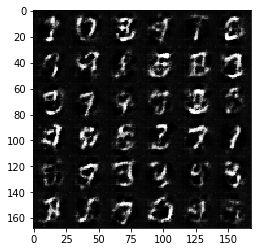

Epoch 1/2... Batch 310... Discriminator Loss: 0.9131... Generator Loss: 1.0349
Epoch 1/2... Batch 320... Discriminator Loss: 0.8791... Generator Loss: 1.2260
Epoch 1/2... Batch 330... Discriminator Loss: 0.8958... Generator Loss: 1.1373
Epoch 1/2... Batch 340... Discriminator Loss: 1.2067... Generator Loss: 0.6392
Epoch 1/2... Batch 350... Discriminator Loss: 1.0444... Generator Loss: 2.2605
Epoch 1/2... Batch 360... Discriminator Loss: 0.9627... Generator Loss: 1.0071
Epoch 1/2... Batch 370... Discriminator Loss: 1.2042... Generator Loss: 2.0705
Epoch 1/2... Batch 380... Discriminator Loss: 1.6167... Generator Loss: 2.8443
Epoch 1/2... Batch 390... Discriminator Loss: 1.1942... Generator Loss: 0.6995
Epoch 1/2... Batch 400... Discriminator Loss: 1.0199... Generator Loss: 1.0542


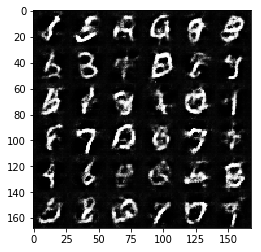

Epoch 1/2... Batch 410... Discriminator Loss: 1.1730... Generator Loss: 0.6986
Epoch 1/2... Batch 420... Discriminator Loss: 1.1802... Generator Loss: 0.7387
Epoch 1/2... Batch 430... Discriminator Loss: 1.0264... Generator Loss: 1.9604
Epoch 1/2... Batch 440... Discriminator Loss: 1.4136... Generator Loss: 0.4919
Epoch 1/2... Batch 450... Discriminator Loss: 1.0467... Generator Loss: 0.9125
Epoch 1/2... Batch 460... Discriminator Loss: 1.5071... Generator Loss: 2.1748
Epoch 1/2... Batch 470... Discriminator Loss: 0.9360... Generator Loss: 1.2734
Epoch 1/2... Batch 480... Discriminator Loss: 1.1544... Generator Loss: 0.7063
Epoch 1/2... Batch 490... Discriminator Loss: 1.1932... Generator Loss: 1.6987
Epoch 1/2... Batch 500... Discriminator Loss: 1.0018... Generator Loss: 1.3364


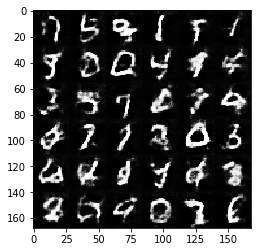

Epoch 1/2... Batch 510... Discriminator Loss: 1.2252... Generator Loss: 0.6258
Epoch 1/2... Batch 520... Discriminator Loss: 1.0410... Generator Loss: 1.0103
Epoch 1/2... Batch 530... Discriminator Loss: 0.9754... Generator Loss: 1.1619
Epoch 1/2... Batch 540... Discriminator Loss: 1.3937... Generator Loss: 2.4175
Epoch 1/2... Batch 550... Discriminator Loss: 1.0286... Generator Loss: 1.0581
Epoch 1/2... Batch 560... Discriminator Loss: 1.1692... Generator Loss: 1.1319
Epoch 1/2... Batch 570... Discriminator Loss: 1.1074... Generator Loss: 1.7620
Epoch 1/2... Batch 580... Discriminator Loss: 1.1006... Generator Loss: 1.3944
Epoch 1/2... Batch 590... Discriminator Loss: 1.0801... Generator Loss: 0.8335
Epoch 1/2... Batch 600... Discriminator Loss: 1.0707... Generator Loss: 0.9885


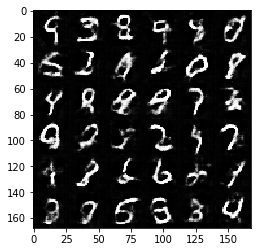

Epoch 1/2... Batch 610... Discriminator Loss: 1.2766... Generator Loss: 1.9772
Epoch 1/2... Batch 620... Discriminator Loss: 1.3814... Generator Loss: 0.5573
Epoch 1/2... Batch 630... Discriminator Loss: 0.9942... Generator Loss: 1.1620
Epoch 1/2... Batch 640... Discriminator Loss: 1.0099... Generator Loss: 1.2172
Epoch 1/2... Batch 650... Discriminator Loss: 1.3194... Generator Loss: 0.5988
Epoch 1/2... Batch 660... Discriminator Loss: 0.9863... Generator Loss: 1.1519
Epoch 1/2... Batch 670... Discriminator Loss: 0.9696... Generator Loss: 1.0865
Epoch 1/2... Batch 680... Discriminator Loss: 1.0447... Generator Loss: 1.1177
Epoch 1/2... Batch 690... Discriminator Loss: 1.3941... Generator Loss: 2.5068
Epoch 1/2... Batch 700... Discriminator Loss: 1.0419... Generator Loss: 1.4973


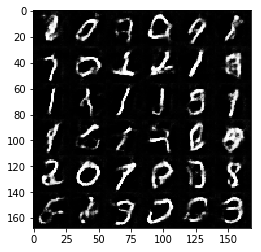

Epoch 1/2... Batch 710... Discriminator Loss: 1.0475... Generator Loss: 0.9351
Epoch 1/2... Batch 720... Discriminator Loss: 1.0447... Generator Loss: 0.9472
Epoch 1/2... Batch 730... Discriminator Loss: 1.0631... Generator Loss: 0.9196
Epoch 1/2... Batch 740... Discriminator Loss: 1.6059... Generator Loss: 0.3948
Epoch 1/2... Batch 750... Discriminator Loss: 1.0854... Generator Loss: 1.0185
Epoch 1/2... Batch 760... Discriminator Loss: 1.1750... Generator Loss: 0.7094
Epoch 1/2... Batch 770... Discriminator Loss: 0.9466... Generator Loss: 1.1943
Epoch 1/2... Batch 780... Discriminator Loss: 1.1132... Generator Loss: 0.9323
Epoch 1/2... Batch 790... Discriminator Loss: 1.0621... Generator Loss: 0.8544
Epoch 1/2... Batch 800... Discriminator Loss: 1.0658... Generator Loss: 0.8338


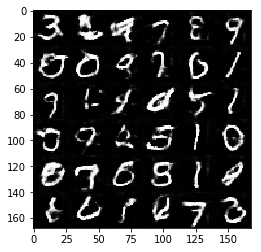

Epoch 1/2... Batch 810... Discriminator Loss: 1.7189... Generator Loss: 0.3546
Epoch 1/2... Batch 820... Discriminator Loss: 0.9553... Generator Loss: 1.0377
Epoch 1/2... Batch 830... Discriminator Loss: 0.9130... Generator Loss: 1.2767
Epoch 1/2... Batch 840... Discriminator Loss: 1.0935... Generator Loss: 1.3681
Epoch 1/2... Batch 850... Discriminator Loss: 1.2793... Generator Loss: 0.5956
Epoch 1/2... Batch 860... Discriminator Loss: 1.7382... Generator Loss: 0.3675
Epoch 1/2... Batch 870... Discriminator Loss: 1.0577... Generator Loss: 0.8404
Epoch 1/2... Batch 880... Discriminator Loss: 1.2639... Generator Loss: 0.5914
Epoch 1/2... Batch 890... Discriminator Loss: 0.9593... Generator Loss: 1.1021
Epoch 1/2... Batch 900... Discriminator Loss: 1.3974... Generator Loss: 0.5319


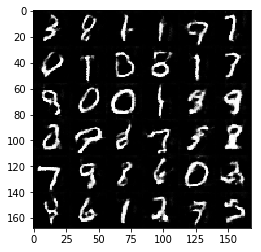

Epoch 1/2... Batch 910... Discriminator Loss: 1.3661... Generator Loss: 0.5364
Epoch 1/2... Batch 920... Discriminator Loss: 1.0163... Generator Loss: 2.1753
Epoch 1/2... Batch 930... Discriminator Loss: 0.9631... Generator Loss: 1.4116
Epoch 2/2... Batch 10... Discriminator Loss: 0.9484... Generator Loss: 1.5685
Epoch 2/2... Batch 20... Discriminator Loss: 1.0173... Generator Loss: 1.0663
Epoch 2/2... Batch 30... Discriminator Loss: 1.3419... Generator Loss: 0.5526
Epoch 2/2... Batch 40... Discriminator Loss: 1.5052... Generator Loss: 0.4814
Epoch 2/2... Batch 50... Discriminator Loss: 1.3119... Generator Loss: 0.5795
Epoch 2/2... Batch 60... Discriminator Loss: 1.1540... Generator Loss: 0.7418
Epoch 2/2... Batch 70... Discriminator Loss: 1.2798... Generator Loss: 0.5949
Epoch 2/2... Batch 80... Discriminator Loss: 1.0010... Generator Loss: 1.0412
Epoch 2/2... Batch 90... Discriminator Loss: 1.0736... Generator Loss: 0.8007
Epoch 2/2... Batch 100... Discriminator Loss: 1.2111... Gener

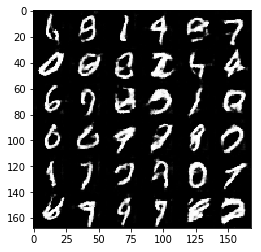

Epoch 2/2... Batch 110... Discriminator Loss: 2.0611... Generator Loss: 0.2582
Epoch 2/2... Batch 120... Discriminator Loss: 1.2015... Generator Loss: 0.7079
Epoch 2/2... Batch 130... Discriminator Loss: 1.1167... Generator Loss: 0.7885
Epoch 2/2... Batch 140... Discriminator Loss: 1.1262... Generator Loss: 0.7987
Epoch 2/2... Batch 150... Discriminator Loss: 1.0005... Generator Loss: 0.9205
Epoch 2/2... Batch 160... Discriminator Loss: 1.2421... Generator Loss: 0.6301
Epoch 2/2... Batch 170... Discriminator Loss: 1.4273... Generator Loss: 0.5684
Epoch 2/2... Batch 180... Discriminator Loss: 1.1450... Generator Loss: 0.7299
Epoch 2/2... Batch 190... Discriminator Loss: 1.0844... Generator Loss: 0.8531
Epoch 2/2... Batch 200... Discriminator Loss: 1.0551... Generator Loss: 0.9164


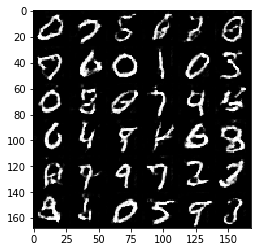

Epoch 2/2... Batch 210... Discriminator Loss: 0.8485... Generator Loss: 1.3351
Epoch 2/2... Batch 220... Discriminator Loss: 0.9966... Generator Loss: 1.0354
Epoch 2/2... Batch 230... Discriminator Loss: 1.0082... Generator Loss: 0.8552
Epoch 2/2... Batch 240... Discriminator Loss: 1.3095... Generator Loss: 0.6850
Epoch 2/2... Batch 250... Discriminator Loss: 1.1117... Generator Loss: 0.7550
Epoch 2/2... Batch 260... Discriminator Loss: 1.2207... Generator Loss: 0.6493
Epoch 2/2... Batch 270... Discriminator Loss: 0.9268... Generator Loss: 1.1888
Epoch 2/2... Batch 280... Discriminator Loss: 0.9047... Generator Loss: 1.2356
Epoch 2/2... Batch 290... Discriminator Loss: 1.0285... Generator Loss: 1.2341
Epoch 2/2... Batch 300... Discriminator Loss: 1.4225... Generator Loss: 0.4781


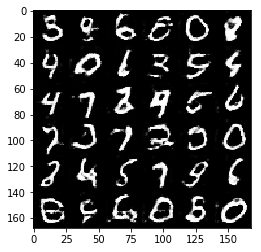

Epoch 2/2... Batch 310... Discriminator Loss: 0.8981... Generator Loss: 1.1328
Epoch 2/2... Batch 320... Discriminator Loss: 1.0340... Generator Loss: 0.8388
Epoch 2/2... Batch 330... Discriminator Loss: 1.1092... Generator Loss: 0.7361
Epoch 2/2... Batch 340... Discriminator Loss: 1.8644... Generator Loss: 0.3343
Epoch 2/2... Batch 350... Discriminator Loss: 1.0758... Generator Loss: 0.8067
Epoch 2/2... Batch 360... Discriminator Loss: 1.0928... Generator Loss: 0.8175
Epoch 2/2... Batch 370... Discriminator Loss: 0.9335... Generator Loss: 1.1760
Epoch 2/2... Batch 380... Discriminator Loss: 0.7758... Generator Loss: 1.3798
Epoch 2/2... Batch 390... Discriminator Loss: 0.8065... Generator Loss: 1.2239
Epoch 2/2... Batch 400... Discriminator Loss: 1.0479... Generator Loss: 0.8409


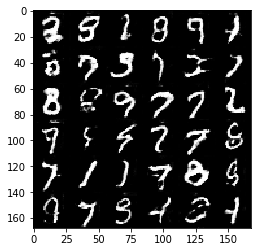

Epoch 2/2... Batch 410... Discriminator Loss: 0.8816... Generator Loss: 1.0222
Epoch 2/2... Batch 420... Discriminator Loss: 1.0438... Generator Loss: 1.1032
Epoch 2/2... Batch 430... Discriminator Loss: 0.9158... Generator Loss: 1.1253
Epoch 2/2... Batch 440... Discriminator Loss: 1.5931... Generator Loss: 0.4453
Epoch 2/2... Batch 450... Discriminator Loss: 1.1516... Generator Loss: 0.8457
Epoch 2/2... Batch 460... Discriminator Loss: 1.0811... Generator Loss: 0.8721
Epoch 2/2... Batch 470... Discriminator Loss: 0.8205... Generator Loss: 1.3356
Epoch 2/2... Batch 480... Discriminator Loss: 0.8868... Generator Loss: 1.1162
Epoch 2/2... Batch 490... Discriminator Loss: 0.8696... Generator Loss: 1.1356
Epoch 2/2... Batch 500... Discriminator Loss: 1.1295... Generator Loss: 0.7180


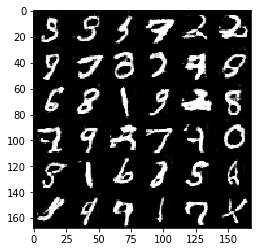

Epoch 2/2... Batch 510... Discriminator Loss: 1.0001... Generator Loss: 0.9101
Epoch 2/2... Batch 520... Discriminator Loss: 0.8162... Generator Loss: 1.8558
Epoch 2/2... Batch 530... Discriminator Loss: 0.9609... Generator Loss: 0.9468
Epoch 2/2... Batch 540... Discriminator Loss: 0.8862... Generator Loss: 1.4338
Epoch 2/2... Batch 550... Discriminator Loss: 0.8680... Generator Loss: 1.6413
Epoch 2/2... Batch 560... Discriminator Loss: 1.1705... Generator Loss: 0.6982
Epoch 2/2... Batch 570... Discriminator Loss: 1.0553... Generator Loss: 2.4266
Epoch 2/2... Batch 580... Discriminator Loss: 0.8818... Generator Loss: 1.1481
Epoch 2/2... Batch 590... Discriminator Loss: 1.1931... Generator Loss: 0.6824
Epoch 2/2... Batch 600... Discriminator Loss: 0.8704... Generator Loss: 1.2754


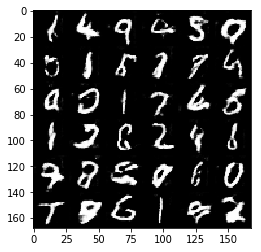

Epoch 2/2... Batch 610... Discriminator Loss: 1.0840... Generator Loss: 0.8168
Epoch 2/2... Batch 620... Discriminator Loss: 0.8281... Generator Loss: 1.2946
Epoch 2/2... Batch 630... Discriminator Loss: 0.8474... Generator Loss: 1.2243
Epoch 2/2... Batch 640... Discriminator Loss: 0.8098... Generator Loss: 1.2868
Epoch 2/2... Batch 650... Discriminator Loss: 1.6763... Generator Loss: 0.3668
Epoch 2/2... Batch 660... Discriminator Loss: 0.9731... Generator Loss: 1.2643
Epoch 2/2... Batch 670... Discriminator Loss: 1.1421... Generator Loss: 1.0146
Epoch 2/2... Batch 680... Discriminator Loss: 0.9869... Generator Loss: 1.0381
Epoch 2/2... Batch 690... Discriminator Loss: 0.9058... Generator Loss: 1.1227
Epoch 2/2... Batch 700... Discriminator Loss: 0.9481... Generator Loss: 2.0258


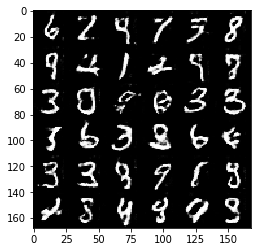

Epoch 2/2... Batch 710... Discriminator Loss: 0.7879... Generator Loss: 1.5183
Epoch 2/2... Batch 720... Discriminator Loss: 0.9438... Generator Loss: 1.2717
Epoch 2/2... Batch 730... Discriminator Loss: 0.9307... Generator Loss: 1.0055
Epoch 2/2... Batch 740... Discriminator Loss: 0.8756... Generator Loss: 1.4014
Epoch 2/2... Batch 750... Discriminator Loss: 0.8383... Generator Loss: 1.4434
Epoch 2/2... Batch 760... Discriminator Loss: 1.3389... Generator Loss: 0.5392
Epoch 2/2... Batch 770... Discriminator Loss: 1.1768... Generator Loss: 0.7021
Epoch 2/2... Batch 780... Discriminator Loss: 1.3497... Generator Loss: 0.5368
Epoch 2/2... Batch 790... Discriminator Loss: 1.8500... Generator Loss: 3.5179
Epoch 2/2... Batch 800... Discriminator Loss: 1.0100... Generator Loss: 0.9741


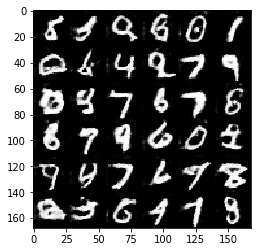

Epoch 2/2... Batch 810... Discriminator Loss: 0.8580... Generator Loss: 1.5392
Epoch 2/2... Batch 820... Discriminator Loss: 0.8527... Generator Loss: 1.2443
Epoch 2/2... Batch 830... Discriminator Loss: 1.4645... Generator Loss: 3.4606
Epoch 2/2... Batch 840... Discriminator Loss: 0.9502... Generator Loss: 1.3093
Epoch 2/2... Batch 850... Discriminator Loss: 1.3228... Generator Loss: 0.5925
Epoch 2/2... Batch 860... Discriminator Loss: 1.2720... Generator Loss: 0.6215
Epoch 2/2... Batch 870... Discriminator Loss: 1.0436... Generator Loss: 0.8366
Epoch 2/2... Batch 880... Discriminator Loss: 0.7949... Generator Loss: 1.1692
Epoch 2/2... Batch 890... Discriminator Loss: 0.9319... Generator Loss: 1.0071
Epoch 2/2... Batch 900... Discriminator Loss: 0.9059... Generator Loss: 1.0050


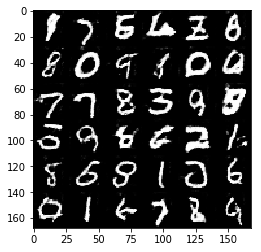

Epoch 2/2... Batch 910... Discriminator Loss: 1.4804... Generator Loss: 0.5564
Epoch 2/2... Batch 920... Discriminator Loss: 0.9346... Generator Loss: 1.4059
Epoch 2/2... Batch 930... Discriminator Loss: 0.8517... Generator Loss: 1.1564


In [30]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.2926... Generator Loss: 0.7415
Epoch 1/1... Batch 20... Discriminator Loss: 1.2960... Generator Loss: 0.5431
Epoch 1/1... Batch 30... Discriminator Loss: 0.6096... Generator Loss: 1.7232
Epoch 1/1... Batch 40... Discriminator Loss: 0.8714... Generator Loss: 12.4185
Epoch 1/1... Batch 50... Discriminator Loss: 0.9259... Generator Loss: 0.9603
Epoch 1/1... Batch 60... Discriminator Loss: 0.4940... Generator Loss: 2.4140
Epoch 1/1... Batch 70... Discriminator Loss: 0.5808... Generator Loss: 3.2093
Epoch 1/1... Batch 80... Discriminator Loss: 0.6278... Generator Loss: 1.8866
Epoch 1/1... Batch 90... Discriminator Loss: 0.6409... Generator Loss: 6.2450
Epoch 1/1... Batch 100... Discriminator Loss: 0.4888... Generator Loss: 2.7631


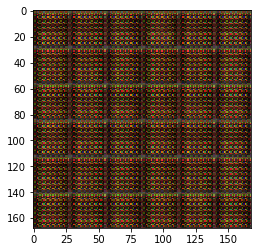

Epoch 1/1... Batch 110... Discriminator Loss: 0.7539... Generator Loss: 1.5411
Epoch 1/1... Batch 120... Discriminator Loss: 1.0129... Generator Loss: 1.2644
Epoch 1/1... Batch 130... Discriminator Loss: 0.9044... Generator Loss: 1.2526
Epoch 1/1... Batch 140... Discriminator Loss: 1.1198... Generator Loss: 0.9429
Epoch 1/1... Batch 150... Discriminator Loss: 1.1044... Generator Loss: 0.7686
Epoch 1/1... Batch 160... Discriminator Loss: 1.9138... Generator Loss: 0.2706
Epoch 1/1... Batch 170... Discriminator Loss: 1.3937... Generator Loss: 0.5786
Epoch 1/1... Batch 180... Discriminator Loss: 1.1377... Generator Loss: 0.9722
Epoch 1/1... Batch 190... Discriminator Loss: 1.0219... Generator Loss: 1.2825
Epoch 1/1... Batch 200... Discriminator Loss: 1.2402... Generator Loss: 1.5646


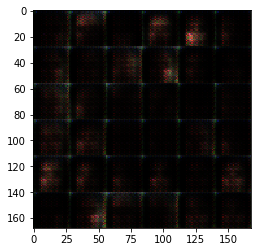

Epoch 1/1... Batch 210... Discriminator Loss: 1.1349... Generator Loss: 0.8886
Epoch 1/1... Batch 220... Discriminator Loss: 1.3116... Generator Loss: 0.6649
Epoch 1/1... Batch 230... Discriminator Loss: 1.0637... Generator Loss: 1.9011
Epoch 1/1... Batch 240... Discriminator Loss: 0.9346... Generator Loss: 1.1810
Epoch 1/1... Batch 250... Discriminator Loss: 1.0919... Generator Loss: 0.9419
Epoch 1/1... Batch 260... Discriminator Loss: 1.1505... Generator Loss: 0.9366
Epoch 1/1... Batch 270... Discriminator Loss: 1.0694... Generator Loss: 1.2251
Epoch 1/1... Batch 280... Discriminator Loss: 1.0165... Generator Loss: 1.1054
Epoch 1/1... Batch 290... Discriminator Loss: 1.3325... Generator Loss: 0.7724
Epoch 1/1... Batch 300... Discriminator Loss: 1.1725... Generator Loss: 0.8091


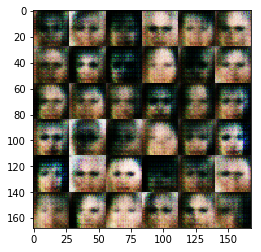

Epoch 1/1... Batch 310... Discriminator Loss: 1.0511... Generator Loss: 0.9512
Epoch 1/1... Batch 320... Discriminator Loss: 1.5530... Generator Loss: 2.4877
Epoch 1/1... Batch 330... Discriminator Loss: 1.5429... Generator Loss: 0.5184
Epoch 1/1... Batch 340... Discriminator Loss: 1.8320... Generator Loss: 0.3557
Epoch 1/1... Batch 350... Discriminator Loss: 1.0264... Generator Loss: 1.4321
Epoch 1/1... Batch 360... Discriminator Loss: 1.3529... Generator Loss: 0.6815
Epoch 1/1... Batch 370... Discriminator Loss: 1.3268... Generator Loss: 0.6553
Epoch 1/1... Batch 380... Discriminator Loss: 0.9409... Generator Loss: 1.3392
Epoch 1/1... Batch 390... Discriminator Loss: 1.1409... Generator Loss: 0.8450
Epoch 1/1... Batch 400... Discriminator Loss: 1.2140... Generator Loss: 0.8460


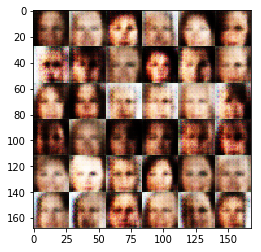

Epoch 1/1... Batch 410... Discriminator Loss: 0.9691... Generator Loss: 1.9235
Epoch 1/1... Batch 420... Discriminator Loss: 0.8952... Generator Loss: 1.8278
Epoch 1/1... Batch 430... Discriminator Loss: 0.6422... Generator Loss: 1.8035
Epoch 1/1... Batch 440... Discriminator Loss: 0.9772... Generator Loss: 1.0159
Epoch 1/1... Batch 450... Discriminator Loss: 1.2182... Generator Loss: 0.6053
Epoch 1/1... Batch 460... Discriminator Loss: 1.5302... Generator Loss: 0.4580
Epoch 1/1... Batch 470... Discriminator Loss: 0.9953... Generator Loss: 1.0710
Epoch 1/1... Batch 480... Discriminator Loss: 1.1602... Generator Loss: 0.7309
Epoch 1/1... Batch 490... Discriminator Loss: 0.9961... Generator Loss: 1.1914
Epoch 1/1... Batch 500... Discriminator Loss: 0.8656... Generator Loss: 2.1665


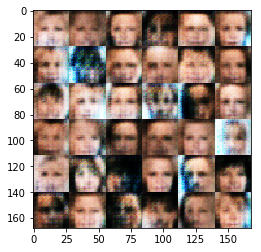

Epoch 1/1... Batch 510... Discriminator Loss: 1.0769... Generator Loss: 1.2733
Epoch 1/1... Batch 520... Discriminator Loss: 1.0827... Generator Loss: 0.9229
Epoch 1/1... Batch 530... Discriminator Loss: 1.2194... Generator Loss: 1.0020
Epoch 1/1... Batch 540... Discriminator Loss: 1.4243... Generator Loss: 0.5222
Epoch 1/1... Batch 550... Discriminator Loss: 1.0352... Generator Loss: 0.9278
Epoch 1/1... Batch 560... Discriminator Loss: 1.2348... Generator Loss: 0.8125
Epoch 1/1... Batch 570... Discriminator Loss: 0.8776... Generator Loss: 1.3502
Epoch 1/1... Batch 580... Discriminator Loss: 1.3225... Generator Loss: 0.6162
Epoch 1/1... Batch 590... Discriminator Loss: 1.1280... Generator Loss: 0.9032
Epoch 1/1... Batch 600... Discriminator Loss: 1.1179... Generator Loss: 0.8379


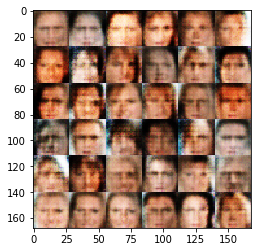

Epoch 1/1... Batch 610... Discriminator Loss: 1.1526... Generator Loss: 0.9551
Epoch 1/1... Batch 620... Discriminator Loss: 1.1980... Generator Loss: 0.9066
Epoch 1/1... Batch 630... Discriminator Loss: 1.0234... Generator Loss: 0.9265
Epoch 1/1... Batch 640... Discriminator Loss: 1.4036... Generator Loss: 0.6538
Epoch 1/1... Batch 650... Discriminator Loss: 1.1780... Generator Loss: 1.0236
Epoch 1/1... Batch 660... Discriminator Loss: 1.3050... Generator Loss: 0.7025
Epoch 1/1... Batch 670... Discriminator Loss: 1.3177... Generator Loss: 0.6234
Epoch 1/1... Batch 680... Discriminator Loss: 0.9246... Generator Loss: 1.2556
Epoch 1/1... Batch 690... Discriminator Loss: 1.0216... Generator Loss: 1.3400
Epoch 1/1... Batch 700... Discriminator Loss: 0.8750... Generator Loss: 1.5532


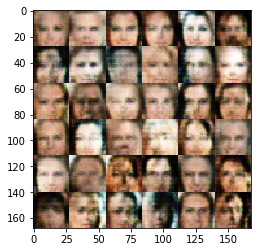

Epoch 1/1... Batch 710... Discriminator Loss: 0.9059... Generator Loss: 1.1974
Epoch 1/1... Batch 720... Discriminator Loss: 0.8305... Generator Loss: 3.0956
Epoch 1/1... Batch 730... Discriminator Loss: 1.1850... Generator Loss: 2.0664
Epoch 1/1... Batch 740... Discriminator Loss: 0.9964... Generator Loss: 1.0049
Epoch 1/1... Batch 750... Discriminator Loss: 0.6433... Generator Loss: 1.9395
Epoch 1/1... Batch 760... Discriminator Loss: 1.4646... Generator Loss: 2.2720
Epoch 1/1... Batch 770... Discriminator Loss: 2.0488... Generator Loss: 0.2406
Epoch 1/1... Batch 780... Discriminator Loss: 0.8631... Generator Loss: 1.4350
Epoch 1/1... Batch 790... Discriminator Loss: 0.7246... Generator Loss: 1.8496
Epoch 1/1... Batch 800... Discriminator Loss: 1.7982... Generator Loss: 0.2963


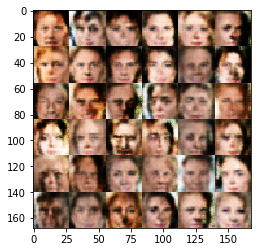

Epoch 1/1... Batch 810... Discriminator Loss: 0.9282... Generator Loss: 1.0848
Epoch 1/1... Batch 820... Discriminator Loss: 0.8320... Generator Loss: 1.4810
Epoch 1/1... Batch 830... Discriminator Loss: 1.5963... Generator Loss: 0.4034
Epoch 1/1... Batch 840... Discriminator Loss: 1.3298... Generator Loss: 0.6747
Epoch 1/1... Batch 850... Discriminator Loss: 1.9999... Generator Loss: 0.2790
Epoch 1/1... Batch 860... Discriminator Loss: 1.0765... Generator Loss: 0.7762
Epoch 1/1... Batch 870... Discriminator Loss: 1.4282... Generator Loss: 0.6378
Epoch 1/1... Batch 880... Discriminator Loss: 1.6390... Generator Loss: 0.4043
Epoch 1/1... Batch 890... Discriminator Loss: 1.0394... Generator Loss: 1.1084
Epoch 1/1... Batch 900... Discriminator Loss: 1.4367... Generator Loss: 0.4759


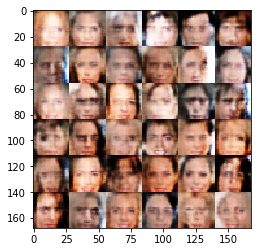

Epoch 1/1... Batch 910... Discriminator Loss: 0.9810... Generator Loss: 3.1486
Epoch 1/1... Batch 920... Discriminator Loss: 0.5681... Generator Loss: 1.9500
Epoch 1/1... Batch 930... Discriminator Loss: 1.0102... Generator Loss: 1.0364
Epoch 1/1... Batch 940... Discriminator Loss: 1.4473... Generator Loss: 0.6480
Epoch 1/1... Batch 950... Discriminator Loss: 1.1491... Generator Loss: 0.9171
Epoch 1/1... Batch 960... Discriminator Loss: 1.5003... Generator Loss: 0.5064
Epoch 1/1... Batch 970... Discriminator Loss: 1.1078... Generator Loss: 1.4443
Epoch 1/1... Batch 980... Discriminator Loss: 1.2151... Generator Loss: 0.8760
Epoch 1/1... Batch 990... Discriminator Loss: 0.7158... Generator Loss: 2.3358
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7795... Generator Loss: 1.4298


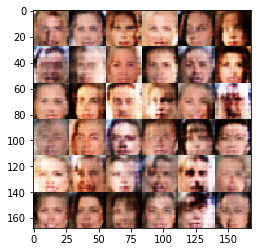

Epoch 1/1... Batch 1010... Discriminator Loss: 1.8318... Generator Loss: 0.3071
Epoch 1/1... Batch 1020... Discriminator Loss: 1.4226... Generator Loss: 0.4728
Epoch 1/1... Batch 1030... Discriminator Loss: 0.8736... Generator Loss: 3.5096
Epoch 1/1... Batch 1040... Discriminator Loss: 0.8199... Generator Loss: 1.3260
Epoch 1/1... Batch 1050... Discriminator Loss: 1.0361... Generator Loss: 1.3346
Epoch 1/1... Batch 1060... Discriminator Loss: 0.9608... Generator Loss: 2.5979
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9282... Generator Loss: 1.4696
Epoch 1/1... Batch 1080... Discriminator Loss: 0.9462... Generator Loss: 1.0825
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3964... Generator Loss: 0.5638
Epoch 1/1... Batch 1100... Discriminator Loss: 1.6767... Generator Loss: 0.3411


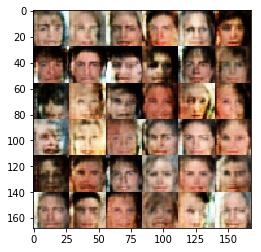

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2908... Generator Loss: 0.5500
Epoch 1/1... Batch 1120... Discriminator Loss: 0.8341... Generator Loss: 1.2380
Epoch 1/1... Batch 1130... Discriminator Loss: 1.0969... Generator Loss: 1.5877
Epoch 1/1... Batch 1140... Discriminator Loss: 1.0718... Generator Loss: 1.2726
Epoch 1/1... Batch 1150... Discriminator Loss: 0.7492... Generator Loss: 1.5380
Epoch 1/1... Batch 1160... Discriminator Loss: 1.5921... Generator Loss: 0.4324
Epoch 1/1... Batch 1170... Discriminator Loss: 1.2219... Generator Loss: 0.9882
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2279... Generator Loss: 0.8091
Epoch 1/1... Batch 1190... Discriminator Loss: 0.7862... Generator Loss: 1.9005
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3545... Generator Loss: 0.5360


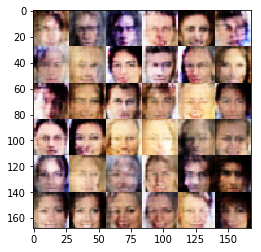

Epoch 1/1... Batch 1210... Discriminator Loss: 0.8950... Generator Loss: 0.9669
Epoch 1/1... Batch 1220... Discriminator Loss: 1.9653... Generator Loss: 0.2806
Epoch 1/1... Batch 1230... Discriminator Loss: 0.9725... Generator Loss: 1.0594
Epoch 1/1... Batch 1240... Discriminator Loss: 0.9915... Generator Loss: 1.3281
Epoch 1/1... Batch 1250... Discriminator Loss: 1.3703... Generator Loss: 0.5177
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0378... Generator Loss: 1.2971
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9745... Generator Loss: 0.8493
Epoch 1/1... Batch 1280... Discriminator Loss: 0.7592... Generator Loss: 1.3820
Epoch 1/1... Batch 1290... Discriminator Loss: 1.0728... Generator Loss: 1.4319
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2756... Generator Loss: 0.7552


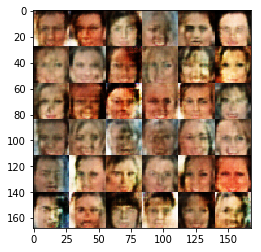

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1269... Generator Loss: 1.0278
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2667... Generator Loss: 1.3894
Epoch 1/1... Batch 1330... Discriminator Loss: 1.4971... Generator Loss: 0.4378
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2517... Generator Loss: 0.7100
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1898... Generator Loss: 1.6018
Epoch 1/1... Batch 1360... Discriminator Loss: 1.3042... Generator Loss: 0.8347
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0087... Generator Loss: 1.2091
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2532... Generator Loss: 0.8268
Epoch 1/1... Batch 1390... Discriminator Loss: 0.7135... Generator Loss: 1.6579
Epoch 1/1... Batch 1400... Discriminator Loss: 0.9600... Generator Loss: 1.0069


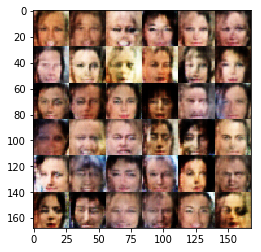

Epoch 1/1... Batch 1410... Discriminator Loss: 0.4045... Generator Loss: 3.4762
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1024... Generator Loss: 0.7535
Epoch 1/1... Batch 1430... Discriminator Loss: 0.9711... Generator Loss: 1.3279
Epoch 1/1... Batch 1440... Discriminator Loss: 0.9010... Generator Loss: 1.6967
Epoch 1/1... Batch 1450... Discriminator Loss: 1.7550... Generator Loss: 0.3278
Epoch 1/1... Batch 1460... Discriminator Loss: 0.9469... Generator Loss: 1.1471
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0054... Generator Loss: 1.6539
Epoch 1/1... Batch 1480... Discriminator Loss: 1.2736... Generator Loss: 0.6471
Epoch 1/1... Batch 1490... Discriminator Loss: 0.8986... Generator Loss: 1.0781
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9527... Generator Loss: 0.9426


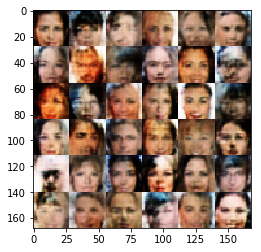

Epoch 1/1... Batch 1510... Discriminator Loss: 0.8411... Generator Loss: 1.4921
Epoch 1/1... Batch 1520... Discriminator Loss: 0.9024... Generator Loss: 1.3701
Epoch 1/1... Batch 1530... Discriminator Loss: 0.7845... Generator Loss: 1.6075
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1913... Generator Loss: 1.2755
Epoch 1/1... Batch 1550... Discriminator Loss: 1.0453... Generator Loss: 1.8227
Epoch 1/1... Batch 1560... Discriminator Loss: 0.7999... Generator Loss: 1.5902
Epoch 1/1... Batch 1570... Discriminator Loss: 0.5427... Generator Loss: 2.1722
Epoch 1/1... Batch 1580... Discriminator Loss: 1.6638... Generator Loss: 0.3661
Epoch 1/1... Batch 1590... Discriminator Loss: 1.1479... Generator Loss: 0.7455
Epoch 1/1... Batch 1600... Discriminator Loss: 1.0292... Generator Loss: 0.8047


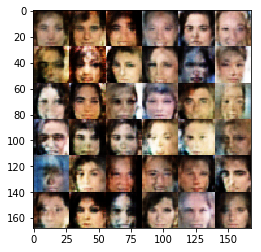

Epoch 1/1... Batch 1610... Discriminator Loss: 0.9234... Generator Loss: 0.9565
Epoch 1/1... Batch 1620... Discriminator Loss: 1.7959... Generator Loss: 0.3481
Epoch 1/1... Batch 1630... Discriminator Loss: 1.7217... Generator Loss: 0.3895
Epoch 1/1... Batch 1640... Discriminator Loss: 0.9960... Generator Loss: 1.0804
Epoch 1/1... Batch 1650... Discriminator Loss: 1.5798... Generator Loss: 2.2119
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9725... Generator Loss: 1.6862
Epoch 1/1... Batch 1670... Discriminator Loss: 0.8952... Generator Loss: 1.6599
Epoch 1/1... Batch 1680... Discriminator Loss: 0.7819... Generator Loss: 1.2622
Epoch 1/1... Batch 1690... Discriminator Loss: 1.4951... Generator Loss: 2.0021
Epoch 1/1... Batch 1700... Discriminator Loss: 1.4453... Generator Loss: 0.4735


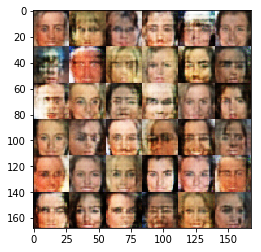

Epoch 1/1... Batch 1710... Discriminator Loss: 0.7037... Generator Loss: 1.7591
Epoch 1/1... Batch 1720... Discriminator Loss: 0.9508... Generator Loss: 1.4169
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1440... Generator Loss: 0.7488
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2093... Generator Loss: 0.9039
Epoch 1/1... Batch 1750... Discriminator Loss: 2.3237... Generator Loss: 0.1726
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3505... Generator Loss: 0.5942
Epoch 1/1... Batch 1770... Discriminator Loss: 0.8672... Generator Loss: 1.0984
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0950... Generator Loss: 1.1007
Epoch 1/1... Batch 1790... Discriminator Loss: 0.7751... Generator Loss: 1.9832
Epoch 1/1... Batch 1800... Discriminator Loss: 0.8622... Generator Loss: 1.1498


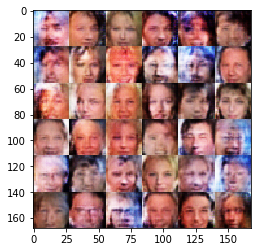

Epoch 1/1... Batch 1810... Discriminator Loss: 1.4667... Generator Loss: 2.3233
Epoch 1/1... Batch 1820... Discriminator Loss: 1.3264... Generator Loss: 0.6089
Epoch 1/1... Batch 1830... Discriminator Loss: 0.9471... Generator Loss: 1.0550
Epoch 1/1... Batch 1840... Discriminator Loss: 1.3500... Generator Loss: 0.7432
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4980... Generator Loss: 0.4632
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2302... Generator Loss: 1.1450
Epoch 1/1... Batch 1870... Discriminator Loss: 1.3088... Generator Loss: 0.5623
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0247... Generator Loss: 0.8215
Epoch 1/1... Batch 1890... Discriminator Loss: 0.9642... Generator Loss: 0.9092
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1507... Generator Loss: 1.0786


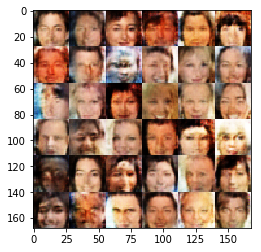

Epoch 1/1... Batch 1910... Discriminator Loss: 0.8286... Generator Loss: 1.2692
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4338... Generator Loss: 0.5033
Epoch 1/1... Batch 1930... Discriminator Loss: 1.0455... Generator Loss: 0.9733
Epoch 1/1... Batch 1940... Discriminator Loss: 0.9413... Generator Loss: 1.0837
Epoch 1/1... Batch 1950... Discriminator Loss: 0.8771... Generator Loss: 1.1491
Epoch 1/1... Batch 1960... Discriminator Loss: 1.4519... Generator Loss: 0.4886
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2090... Generator Loss: 0.7253
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1913... Generator Loss: 0.6739
Epoch 1/1... Batch 1990... Discriminator Loss: 0.7680... Generator Loss: 1.6942
Epoch 1/1... Batch 2000... Discriminator Loss: 0.9805... Generator Loss: 1.4164


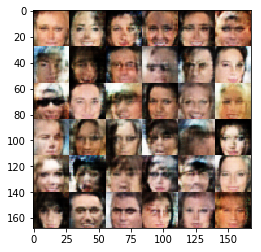

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0776... Generator Loss: 0.9442
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2796... Generator Loss: 0.6248
Epoch 1/1... Batch 2030... Discriminator Loss: 1.0705... Generator Loss: 0.9454
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1350... Generator Loss: 1.1246
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9023... Generator Loss: 1.0427
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1902... Generator Loss: 0.7086
Epoch 1/1... Batch 2070... Discriminator Loss: 1.4031... Generator Loss: 0.5529
Epoch 1/1... Batch 2080... Discriminator Loss: 0.9881... Generator Loss: 1.2026
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0799... Generator Loss: 1.4564
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0055... Generator Loss: 0.8780


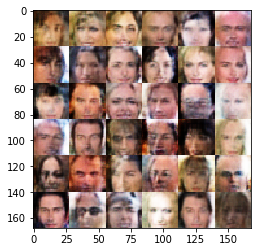

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2186... Generator Loss: 1.8721
Epoch 1/1... Batch 2120... Discriminator Loss: 0.9914... Generator Loss: 1.3123
Epoch 1/1... Batch 2130... Discriminator Loss: 1.3319... Generator Loss: 1.3885
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3345... Generator Loss: 0.6116
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1404... Generator Loss: 0.7903
Epoch 1/1... Batch 2160... Discriminator Loss: 0.7925... Generator Loss: 1.2983
Epoch 1/1... Batch 2170... Discriminator Loss: 1.1686... Generator Loss: 1.0741
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1983... Generator Loss: 0.6175
Epoch 1/1... Batch 2190... Discriminator Loss: 1.0940... Generator Loss: 1.1751
Epoch 1/1... Batch 2200... Discriminator Loss: 0.7385... Generator Loss: 1.6112


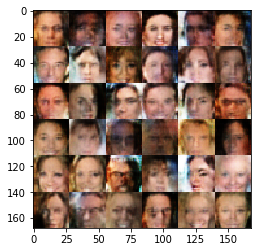

Epoch 1/1... Batch 2210... Discriminator Loss: 0.9675... Generator Loss: 1.0349
Epoch 1/1... Batch 2220... Discriminator Loss: 1.4590... Generator Loss: 0.4765
Epoch 1/1... Batch 2230... Discriminator Loss: 1.4565... Generator Loss: 0.5046
Epoch 1/1... Batch 2240... Discriminator Loss: 2.1895... Generator Loss: 0.2188
Epoch 1/1... Batch 2250... Discriminator Loss: 1.2662... Generator Loss: 0.6657
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2645... Generator Loss: 0.8795


In [31]:
batch_size = 32
z_dim = 110
learning_rate = 0.00025
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.